In [13]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Extract Data

In [2]:
df = pd.read_csv("seattle.csv")
df.head()

,Total Water (in)
0,0.046
1,0.003
2,0.025
3,0.018
4,0.061


In [3]:
roof_width_ft = 20
roof_length_ft = 16
roof_area_ft2 = roof_width_ft * roof_length_ft
roof_area_in2 = roof_area_ft2 * 144
gallons_per_inch3 = 0.00432900433
efficency_factor = 0.8

In [4]:
df["Collected Rainwater (gal)"] = (
    df["Total Water (in)"] * roof_area_in2 * gallons_per_inch3 * efficency_factor
)
df.head()

,Total Water (in),Collected Rainwater (gal)
0,0.046,7.340883
1,0.003,0.478753
2,0.025,3.989610
3,0.018,2.872519
4,0.061,9.734649


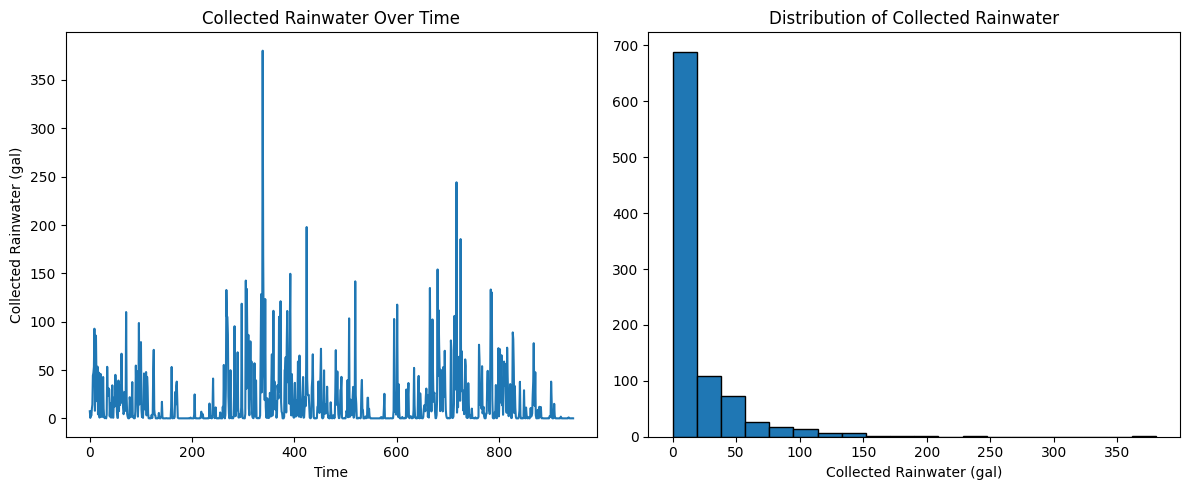

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(df["Collected Rainwater (gal)"])
axs[0].set_title("Collected Rainwater Over Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Collected Rainwater (gal)")

axs[1].hist(df["Collected Rainwater (gal)"], bins=20, edgecolor="black")
axs[1].set_title("Distribution of Collected Rainwater")
axs[1].set_xlabel("Collected Rainwater (gal)")

plt.tight_layout()
plt.show()

# Rough Simulation
* <b>Tank-Size</b>: 50 - 2000 gallons in 10 gallon steps
* <b>Sample Size</b>: 250

In [43]:
collected_rainwater_arr = df["Collected Rainwater (gal)"].values

In [73]:
def simulate(tank_size: float) -> tuple[np.ndarray, np.ndarray]:
    tank_levels = []
    tank_level = tank_size
    water_usage_arr = np.random.normal(
        loc=10.3025, scale=1.3571, size=len(collected_rainwater_arr)
    )
    for collected_rainwater, water_usage in zip(
        collected_rainwater_arr, water_usage_arr
    ):
        tank_level = min(
            max(tank_level + collected_rainwater - water_usage, 0), tank_size
        )
        tank_levels.append(tank_level)

    return np.array(tank_levels)

In [74]:
sample_size = 250
simulation_results = []
for tank_size in range(50, 2050, 10):
    tank_size_results = []
    for _ in range(sample_size):
        tank_levels = simulate(tank_size)
        tank_size_results.append(np.any(tank_levels == 0))
    simulation_results.append(tank_size_results)

simulation_results_arr = np.array(simulation_results)

# Proportion Interval

In [75]:
def confidence_interval_proportion(
    p: float, n: int, confidence_level=0.95
) -> tuple[float, float]:
    """
    Calculate the confidence interval for a proportion.

    Args:
        p (float): The sample proportion (number of successes divided by the total number of trials).
        n (int): The total number of trials (sample size).
        confidence_level (float): The confidence level for the interval (default is 0.95).

    Returns:
        tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """
    q = 1 - p
    z = float(-norm.ppf((1 - confidence_level) / 2))
    p_tilde = (p + (z**2) / (2 * n)) / (1 + (z**2) / n)
    lower_bound = p_tilde - z * (math.sqrt((p * q) / n + (z**2) / (4 * n**2))) / (
        1 + (z**2) / n
    )
    upper_bound = p_tilde + z * (math.sqrt((p * q) / n + (z**2) / (4 * n**2))) / (
        1 + (z**2) / n
    )

    return lower_bound, upper_bound

In [76]:
proportion_confidence_intervals = []
sample_size = simulation_results_arr.shape[1]
for p in simulation_results_arr.mean(axis=1):
    proportion_confidence_intervals.append(
        confidence_interval_proportion(p, sample_size)
    )

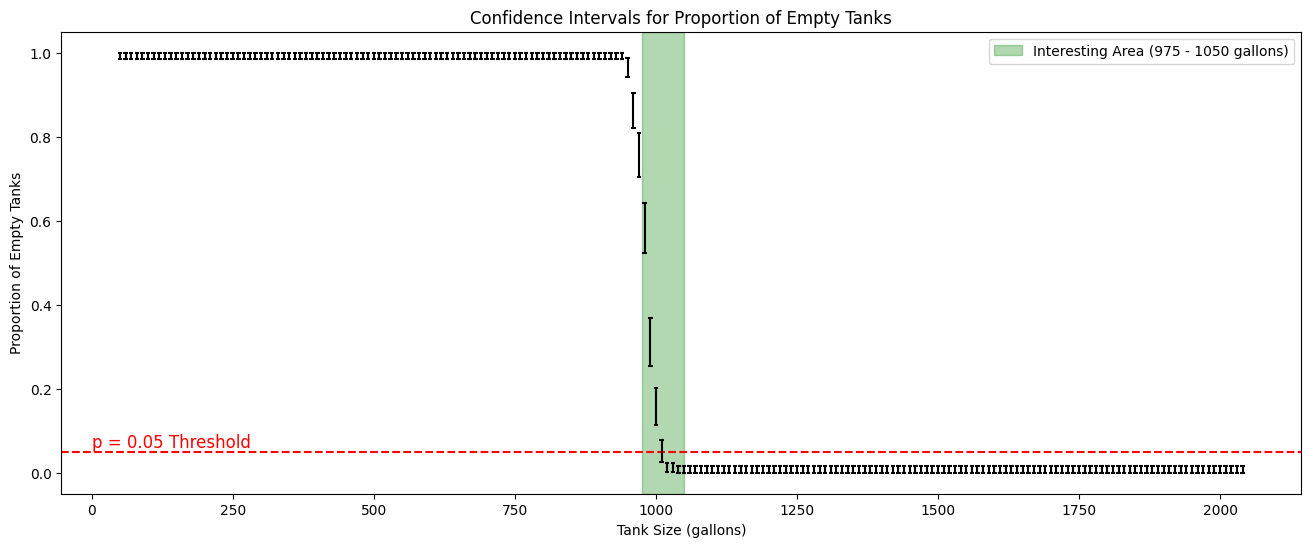

In [79]:
plt.figure(figsize=(16, 6))

plt.axvspan(
    975, 1050, color="green", alpha=0.3, label="Interesting Area (975 - 1050 gallons)"
)
plt.axhline(0.05, color="red", linestyle="--")
plt.text(0, 0.06, "p = 0.05 Threshold", color="red", fontsize=12)
for i, ci in enumerate(proportion_confidence_intervals):
    plt.vlines(i * 10 + 50, ci[0], ci[1], color="black")
    plt.hlines(ci[0], i * 10 + 46, i * 10 + 54, color="black")
    plt.hlines(ci[1], i * 10 + 46, i * 10 + 54, color="black")

plt.title("Confidence Intervals for Proportion of Empty Tanks")
plt.xlabel("Tank Size (gallons)")
plt.ylabel("Proportion of Empty Tanks")
plt.legend()

plt.show()

# Narrow Simulation
* <b>Tank-Size</b>: 975 - 1050 gallons in 1 gallon step
* <b>Sample Size</b>: 250

In [85]:
sample_size = 250
simulation_results = []
for tank_size in range(975, 1051, 1):
    tank_size_results = []
    for _ in range(sample_size):
        tank_levels = simulate(tank_size)
        tank_size_results.append(np.any(tank_levels == 0))
    simulation_results.append(tank_size_results)

simulation_results_arr = np.array(simulation_results)

In [86]:
proportion_confidence_intervals = []
sample_size = simulation_results_arr.shape[1]
for p in simulation_results_arr.mean(axis=1):
    proportion_confidence_intervals.append(
        confidence_interval_proportion(p, sample_size)
    )

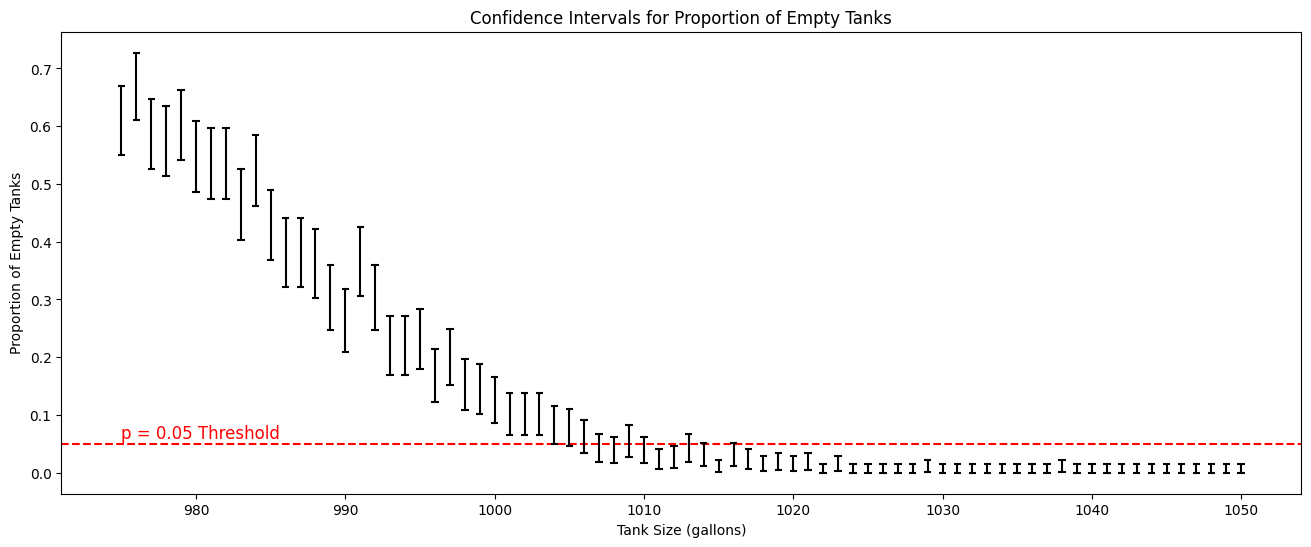

In [87]:
plt.figure(figsize=(16, 6))
plt.axhline(0.05, color="red", linestyle="--")
plt.text(975, 0.06, "p = 0.05 Threshold", color="red", fontsize=12)
for i, ci in enumerate(proportion_confidence_intervals):
    plt.vlines(i * 1 + 975, ci[0], ci[1], color="black")
    plt.hlines(ci[0], i * 1 + 974.75, i * 1 + 975.25, color="black")
    plt.hlines(ci[1], i * 1 + 974.75, i * 1 + 975.25, color="black")

plt.title("Confidence Intervals for Proportion of Empty Tanks")
plt.xlabel("Tank Size (gallons)")
plt.ylabel("Proportion of Empty Tanks")

plt.show()